# VN-Index Cleaning and Exploration

This notebook downloads the specified Kaggle dataset, applies a repeatable cleaning pipeline, generates diagnostic visualizations, and exports the processed data as a CSV file ready for AI forecasting.


In [1]:
import json
from pathlib import Path

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("seaborn-v0_8")


/Users/sofnb25/Documents/MS34/MSA34 - Python/Project/demo_python_basic/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

def download_dataset(dataset_id: str) -> Path:
    """Download a Kaggle dataset using kagglehub and return the download directory."""
    download_path = Path(kagglehub.dataset_download(dataset_id))
    print(f"Dataset downloaded to: {download_path}")
    return download_path

def select_csv_file(download_path: Path, search_terms: list[str]) -> Path:
    """Select the most relevant CSV file inside the dataset directory."""
    csv_files = sorted(download_path.rglob("*.csv"))
    if not csv_files:
        raise FileNotFoundError("No CSV files were found in the downloaded dataset directory.")

    search_terms_lower = [term.lower() for term in search_terms]
    for csv_file in csv_files:
        filename = csv_file.name.lower()
        if any(term in filename for term in search_terms_lower):
            print(f"Selected CSV file: {csv_file}")
            return csv_file

    print("No CSV file matched the search terms; using the first CSV found.")
    return csv_files[0]

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Rename common financial columns to a consistent schema."""
    column_mapping = {
        "date": "date",
        "datetime": "date",
        "timestamp": "date",
        "close": "close",
        "close/last": "close",
        "closing price": "close",
        "adj close": "close",
        "adjusted close": "close",
        "close price": "close",
        "close*": "close",
        "open": "open",
        "open/last": "open",
        "high": "high",
        "low": "low",
        "volume": "volume",
    }

    rename_dict: dict[str, str] = {}
    for column in df.columns:
        normalized = column.strip().lower()
        if normalized in column_mapping:
            rename_dict[column] = column_mapping[normalized]

    df = df.rename(columns=rename_dict)

    if "close" not in df.columns:
        raise KeyError("The dataset does not contain a recognizable close price column.")

    if "date" not in df.columns:
        raise KeyError("The dataset does not contain a recognizable date column.")

    return df

def coerce_numeric_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Convert string-based numeric columns to floats."""
    numeric_candidates = [col for col in df.columns if col != "date"]

    for column in numeric_candidates:
        df[column] = (
            df[column]
            .astype(str)
            .str.replace(",", "", regex=False)
            .str.replace("$", "", regex=False)
            .str.replace("%", "", regex=False)
        )
        df[column] = pd.to_numeric(df[column], errors="coerce")

    return df

def clean_dataframe(df: pd.DataFrame, start_date: str | None, end_date: str | None) -> pd.DataFrame:
    """Apply chronological sorting, type conversion, filtering, and deduplication."""
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date", "close"])
    df = df.sort_values("date")
    df = df.drop_duplicates(subset="date", keep="last")

    df = coerce_numeric_columns(df)

    if start_date:
        df = df[df["date"] >= pd.to_datetime(start_date)]
    if end_date:
        df = df[df["date"] <= pd.to_datetime(end_date)]

    df = df.dropna(subset=["close"])

    return df.reset_index(drop=True)

def export_dataframe(df: pd.DataFrame, output_path: Path) -> None:
    output_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(output_path, index=False)
    print(f"Clean dataset saved to: {output_path}")

def summarize_dataframe(df: pd.DataFrame) -> dict[str, float]:
    summary = {
        "start_date": df["date"].min().date().isoformat() if not df.empty else None,
        "end_date": df["date"].max().date().isoformat() if not df.empty else None,
        "row_count": int(len(df)),
        "missing_close": int(df["close"].isna().sum()),
    }
    print(json.dumps(summary, indent=2))
    return summary

def enforce_ohlc_logic_if_present(df: pd.DataFrame) -> pd.DataFrame:
    """
    Nếu dataset có đủ open/high/low/close thì đảm bảo:
      High >= max(Open, Close) và Low <= min(Open, Close)
    Nếu không có đủ OHLC thì return df như cũ.
    """
    cols = set(df.columns.str.lower())
    need = {"open", "high", "low", "close"}
    if need.issubset(cols):
        # đồng nhất tên cột viết thường → dùng đúng cột đang có
        _m = {c.lower(): c for c in df.columns}
        hi = _m["high"]; lo = _m["low"]; op = _m["open"]; cl = _m["close"]
        df[hi] = df[[hi, op, cl]].max(axis=1)
        df[lo] = df[[lo, op, cl]].min(axis=1)
    return df

def plot_dataset(df: pd.DataFrame, title: str) -> None:
    if df.empty:
        print("No data available to plot.")
        return

    plt.figure(figsize=(12, 4))
    plt.plot(df["date"], df["close"], label="Close Price", color="royalblue")
    plt.title(f"{title} — Closing Price Over Time")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

    df["year"] = df["date"].dt.year
    plt.figure(figsize=(10, 4))
    df.boxplot(column="close", by="year", grid=False)
    plt.title(f"{title} — Distribution of Close Price by Year")
    plt.suptitle("")
    plt.xlabel("Year")
    plt.ylabel("Close Price")
    plt.tight_layout()
    plt.show()

    df.drop(columns="year", inplace=True)


In [3]:
DATASET_ID = "mrdivein/vnindex-historical-data-mar2015-mar-2023"
SEARCH_TERMS = ["vnindex", "vn-index"]
OUTPUT_PATH = DATA_DIR / "vnindex_cleaned.csv"
START_DATE = "2018-01-01"
END_DATE = "2023-03-31"

Dataset downloaded to: /Users/sofnb25/.cache/kagglehub/datasets/mrdivein/vnindex-historical-data-mar2015-mar-2023/versions/1
Selected CSV file: /Users/sofnb25/.cache/kagglehub/datasets/mrdivein/vnindex-historical-data-mar2015-mar-2023/versions/1/vnindex_historical_Mar2015_Mar2023.csv
{
  "start_date": "2018-01-02",
  "end_date": "2023-03-22",
  "row_count": 1303,
  "missing_close": 0
}


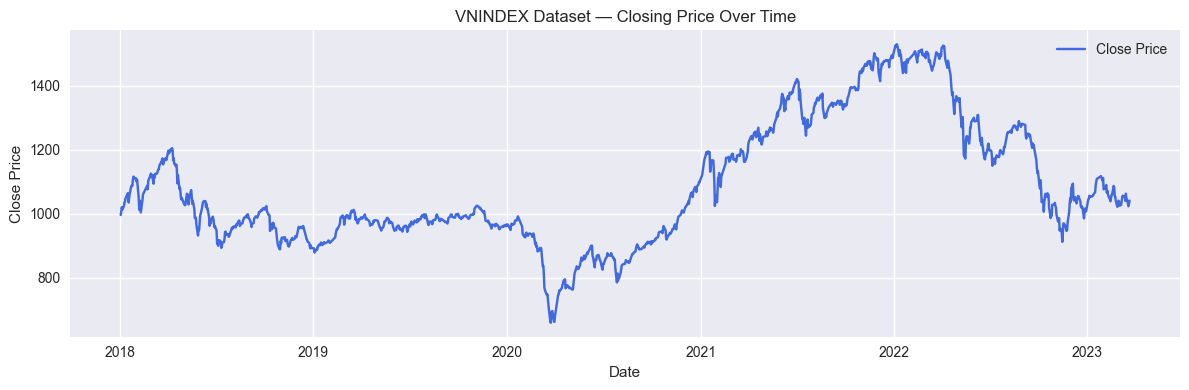

<Figure size 1000x400 with 0 Axes>

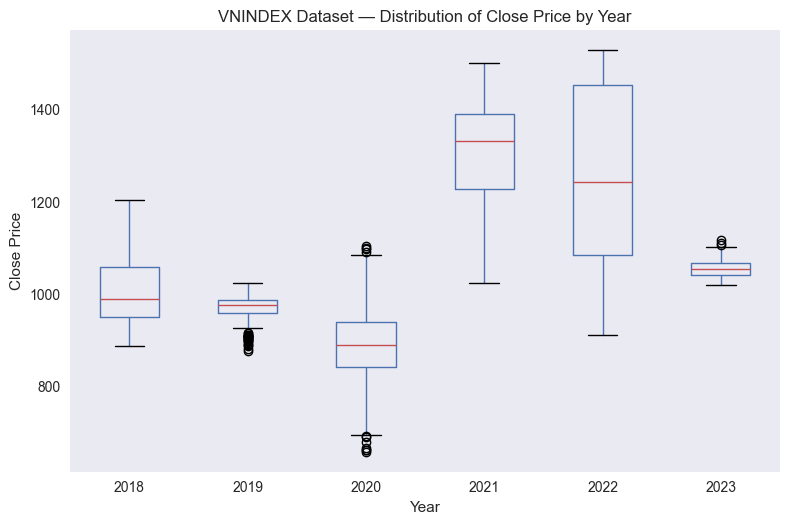

Clean dataset saved to: data/vnindex_cleaned.csv


,date,Change,open,high,low,close,volume,Value,Market_Cap
0,2018-01-02,1.17,986.05,996.18,984.24,995.77,185285246.0,5605.48,2648603.45
1,2018-01-03,0.99,999.86,1010.21,995.77,1005.67,236216643.0,6230.89,2676084.71
2,2018-01-04,1.40,1009.37,1019.75,1005.67,1019.75,251786350.0,6099.10,2715278.54
3,2018-01-05,-0.70,1020.34,1020.60,1010.65,1012.65,281983216.0,7516.39,2734762.02
4,2018-01-08,1.01,1011.36,1022.90,1004.89,1022.90,267791885.0,7181.35,2761445.07


In [4]:
download_path = download_dataset(DATASET_ID)
raw_csv_path = select_csv_file(download_path, SEARCH_TERMS)
raw_df = pd.read_csv(raw_csv_path)

standardized_df = standardize_columns(raw_df)
clean_df = clean_dataframe(standardized_df, start_date=START_DATE, end_date=END_DATE)
clean_df = enforce_ohlc_logic_if_present(clean_df)
summary = summarize_dataframe(clean_df)

plot_dataset(clean_df, title=f"{SEARCH_TERMS[0].upper()} Dataset")
export_dataframe(clean_df, OUTPUT_PATH)
clean_df.head()